In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import plotly.express as px
import plotly.graph_objects as go


/Users/pedrohd/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### CREACIÓN DE DATASETS

In [2]:
df_orders = pd.read_excel('./datasets/df_orders.xlsx')
df_vehicle = pd.read_excel('./datasets/df_vehicle.xlsx')
df_location = pd.read_excel('./datasets/df_location.xlsx')
df_historic_orders = pd.read_excel('./datasets/df_historic_order_demand.xlsx')
df_distance_min = pd.read_excel('./datasets/df_distance_min.xlsx')
df_distance_km = pd.read_excel('./datasets/df_distance_km.xlsx')

### ANÁLISIS DESCRIPTIVO

Lo primero determinamos cual es el objetivo a la hora de horientar nuestro modelo. Para ello determinaremos cuáles pueden ser nuestras tablas en las que apoyar todo nuestro trabajo. Para ello vemos que la tabla de orders e historic_order_demand son las más relevantes para dicho análisis.

Decidimos separar la columna de mes_año por dos columnas. Siendo estas dos mes y año.

In [3]:
df_orders[["mes", "año"]] = df_orders["mes_anio"].str.split("-", expand=True).astype(int)
df_orders.drop(columns=["mes_anio"], inplace=True)

df_historic_orders[["mes", "año"]] = df_historic_orders["mes_anio"].str.split("-", expand=True).astype(int)
df_historic_orders.drop(columns=["mes_anio"], inplace=True)

In [4]:
df_historic_orders.head(5)

,cliente,order_demand,mes,año
0,Cliente_1,857.0,12,2020
1,Cliente_2,941.0,12,2020
2,Cliente_3,878.0,12,2020
3,Cliente_4,949.0,12,2020
4,Cliente_5,932.0,12,2020


In [5]:
print("Dimensiones de las distancias en Kilómetros:", df_distance_km.shape)
print("Dimensiones de las distancias en Minutos:", df_distance_min.shape)

Dimensiones de las distancias en Kilómetros: (21, 21)
Dimensiones de las distancias en Minutos: (21, 21)


In [6]:
# Resumen estadístico de las distancias
print("\nResumen de las distancias en Kilómetros:")
df_distance_km.describe()


Resumen de las distancias en Kilómetros:


,Cliente_1,Cliente_2,Cliente_3,Cliente_4,Cliente_5,Cliente_6,Cliente_7,Cliente_8,Cliente_9,Cliente_10,...,Cliente_12,Cliente_13,Cliente_14,Cliente_15,Cliente_16,Cliente_17,Cliente_18,Cliente_19,Cliente_20,Almacén
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.00000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,7.536357,9.864667,10.621152,7.357362,6.802043,7.300319,7.347762,14.801343,9.005157,6.969476,...,8.61580,7.477371,6.412200,11.903781,6.763238,13.919776,9.823352,17.276176,21.866819,8.631705
std,6.507082,5.641242,6.779304,6.330445,6.880651,6.645782,6.197532,7.426677,7.157035,5.559162,...,4.96885,4.589039,7.219545,8.478654,6.121545,8.052023,4.848233,6.379736,7.397041,6.311671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.213300,7.152100,5.011400,2.879900,2.625300,2.695200,0.000000,12.916100,3.578100,3.345100,...,5.90510,4.989600,0.000000,5.974200,2.057500,9.756500,8.273700,14.710500,19.103800,3.611400
50%,5.447000,9.636900,12.543800,5.072100,5.072100,4.818700,7.886600,14.862300,7.722900,5.951600,...,6.87380,6.445100,3.647600,11.361000,4.835500,11.400800,9.145600,19.746700,22.144500,7.989500
75%,10.828800,13.797400,15.728900,11.192600,9.106400,11.400800,10.296800,17.409500,13.225500,8.219600,...,10.29680,10.067500,10.070800,15.608400,9.682400,20.013800,11.998100,21.049200,24.121500,13.292300
max,22.144500,19.821800,22.059900,21.151800,25.594700,20.479700,20.013800,34.136800,24.567000,21.140700,...,22.59620,17.718700,23.896900,37.006000,21.035100,30.641200,24.373400,26.142100,37.006000,22.036800


In [7]:

print("\nResumen de las distancias en Minutos:")
df_distance_min.describe()


Resumen de las distancias en Minutos:


,Cliente_1,Cliente_2,Cliente_3,Cliente_4,Cliente_5,Cliente_6,Cliente_7,Cliente_8,Cliente_9,Cliente_10,...,Cliente_12,Cliente_13,Cliente_14,Cliente_15,Cliente_16,Cliente_17,Cliente_18,Cliente_19,Cliente_20,Almacén
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,11.483810,15.100794,14.506349,11.542381,9.690794,10.801111,11.923889,18.555317,13.257143,11.199206,...,12.020794,13.166587,8.616270,15.127698,10.610714,17.975635,15.028095,20.440079,23.705238,12.788730
std,7.368238,6.575722,8.239668,7.505616,7.781569,7.467207,9.021039,7.352808,8.189932,6.750769,...,5.814432,6.053764,7.822059,7.900947,7.531920,8.377968,5.818002,6.242652,6.896724,7.204663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.098333,14.023333,11.541667,6.181667,5.120000,6.033333,0.000000,16.505000,7.165000,7.185000,...,8.793333,10.768333,0.000000,10.558333,3.733333,13.400000,13.591667,19.335000,21.898333,7.400000
50%,10.028333,15.798333,17.378333,10.501667,8.793333,9.711667,14.550000,20.700000,13.025000,11.058333,...,10.501667,13.838333,7.391667,17.495000,9.428333,18.026667,14.931667,22.341667,24.420000,11.388333
75%,15.838333,20.061667,19.651667,16.546667,13.871667,17.068333,18.298333,22.668333,19.981667,13.976667,...,14.550000,17.495000,13.838333,19.730000,16.261667,23.763333,16.181667,23.855000,28.093333,19.730000
max,23.855000,26.153333,27.531667,24.328333,28.093333,23.876667,26.281667,30.101667,25.875000,26.283333,...,28.981667,23.763333,25.035000,32.211667,24.420000,30.111667,31.866667,30.111667,32.211667,23.798333


Creamos nuevos datasets para ver la disntacia tanto en kilometros como del almacén de los diferentes clientes

In [8]:
df_distacia_almacen_km = df_distance_km[["Almacén"]].copy()
df_distacia_almacen_km["cliente"] = df_distance_km.index + 1

In [9]:
df_distacia_almacen_min = df_distance_min[["Almacén"]].copy()
df_distacia_almacen_min["cliente"] = df_distance_min.index + 1

Estandarizamos la columna de clientes en los diferentes datasets

In [10]:
def estandarizar_cliente(cliente):
    if isinstance(cliente, int):
        return f'cliente_{cliente}'
    else:
        return str(cliente).strip().lower()


datasets = [df_historic_orders, df_orders, df_distacia_almacen_km, df_distacia_almacen_min]
for df in datasets:
    df["cliente"] = df["cliente"].apply(estandarizar_cliente)


In [11]:
df_historic_orders.head(5)

,cliente,order_demand,mes,año
0,cliente_1,857.0,12,2020
1,cliente_2,941.0,12,2020
2,cliente_3,878.0,12,2020
3,cliente_4,949.0,12,2020
4,cliente_5,932.0,12,2020


In [12]:
df_distacia_almacen_min.head(5)

,Almacén,cliente
0,6.905000,cliente_1
1,20.381667,cliente_2
2,20.873333,cliente_3
3,7.400000,cliente_4
4,7.938333,cliente_5


#### Relación entre la Distancia del Almacén y la Demanda de Pedidos

In [13]:
total_demand_per_client = df_historic_orders.groupby('cliente').agg({'order_demand': 'sum'}).reset_index()
total_demand_per_client

,cliente,order_demand
0,cliente_1,34387.0
1,cliente_10,32426.0
2,cliente_11,31300.0
3,cliente_12,32284.0
4,cliente_13,30914.0
5,cliente_14,32193.0
6,cliente_15,33118.0
7,cliente_16,32156.0
8,cliente_17,32982.0
9,cliente_18,32970.0


In [14]:
df_distance_demand = pd.merge(df_distacia_almacen_km, total_demand_per_client, on='cliente')

fig = px.scatter(df_distance_demand, x='Almacén', y='order_demand', text='cliente', title='Relación entre la Distancia del Almacén y la Demanda de Pedidos')
fig.update_layout(xaxis_title='Distancia al Almacén (km)', yaxis_title='Demanda Total de Pedidos (kg)')
fig.show()

#### Relación entre el tiempo Almacén-Cliente y la Demanda de Pedidos

In [15]:
df_time_demand = pd.merge(df_distacia_almacen_min, total_demand_per_client, on='cliente')

fig = px.scatter(df_time_demand, x='Almacén', y='order_demand', text='cliente', title='Relación entre la tiempo Almacén-Cliente y la Demanda de Pedidos')
fig.update_layout(xaxis_title='Tiempo desde el almacén(minutos)', yaxis_title='Demanda Total de Pedidos (kg)')
fig.show()

#### Demanda mensual histórica por mes

In [16]:
# Calcular la demanda mensual total
df_monthly_demand = df_historic_orders.groupby(['año', 'mes']).agg({'order_demand': 'sum'}).reset_index()

# Crear el gráfico de demanda mensual total
fig = px.line(df_monthly_demand, x='mes', y='order_demand', color='año', markers=True, title='Demanda Mensual Histórica')
fig.update_layout(xaxis_title='Mes', yaxis_title='Demanda Total (kg)')
fig.show()

#### Distribución de la demanda de pedidos en el último mes.

In [17]:
fig1 = px.histogram(df_orders, x='order_demand', nbins=10, title='Distribución de la Demanda de Pedidos en el Último Mes')
fig1.update_layout(xaxis_title='Demanda de Pedidos (kg)', yaxis_title='Frecuencia')
fig1.show()

Demanda en kg por cliente en Diciembre de 2024

In [18]:
fig1 = px.histogram(df_orders, x='cliente',y='order_demand', nbins=10, title='Demanda en kg por cliente en Diciembre de 2024')
fig1.update_layout(xaxis_title='Cliente', yaxis_title='Demanda en kg')
fig1.show()

#### Tendencia de la demanda histórica de pedidos.

In [19]:
fig2 = px.line(df_historic_orders, x='año', y='order_demand', color='cliente', markers=True, title='Tendencia de la Demanda Histórica de Pedidos')
fig2.update_layout(xaxis_title='Año', yaxis_title='Demanda de Pedidos (kg)')
fig2.show()


#### Capacidad y Costo por km de los Vehículos

In [20]:
fig3 = px.scatter(df_vehicle, x='capacidad_kg',
                  
                y='costo_km', 
                size='autonomia_km',
                color= 'vehiculo_id', 
                text='vehiculo_id', 
                title='Relación entre capacidad, coste y autonomía de los vehículos',
                color_continuous_scale='Blues')

fig3.update_layout(xaxis_title='Capacidad (kg)', yaxis_title='Costo por km')
fig3.show()

#### Localización geográfica de los clientes

In [21]:
geolocator = Nominatim(user_agent="myApp")

def obtener_municipio(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location and 'address' in location.raw:
            return location.raw['address'].get('suburb', location.raw['address'].get('city_district', 'No encontrado'))
    except GeocoderTimedOut:
        return 'Timeout'
    time.sleep(1)
    return 'No encontrado'

df_location['Municipio'] = df_location.apply(lambda row: obtener_municipio(row['Latitud'], row['Longitud']), axis=1)
df_location


,Cliente,Latitud,Longitud,Municipio
0,Cliente_1,40.402828,-3.696878,Arganzuela
1,Cliente_2,40.455820,-3.700350,Tetuán
2,Cliente_3,40.471840,-3.708079,Fuencarral-El Pardo
3,Cliente_4,40.404688,-3.706262,Arganzuela
4,Cliente_5,40.371990,-3.695056,Usera
5,Cliente_6,40.400481,-3.712361,Arganzuela
6,Cliente_7,40.457059,-3.703511,Tetuán
7,Cliente_8,40.446872,-3.586515,San Blas - Canillejas
8,Cliente_9,40.389637,-3.735354,Carabanchel
9,Cliente_10,40.409083,-3.676125,Retiro


In [22]:
def obtener_calle(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location and 'address' in location.raw:
            return f"{location.raw['address'].get('road')} {location.raw['address'].get('house_number', '')}, {location.raw['address'].get('postcode')}, {location.raw['address'].get('city')}, {location.raw['address'].get('country')}"
    except GeocoderTimedOut:
        return 'Timeout'
    time.sleep(1)
    return 'No encontrado'

df_location['Dirección'] = df_location.apply(lambda row: obtener_calle(row['Latitud'], row['Longitud']), axis=1)
df_location

,Cliente,Latitud,Longitud,Municipio,Dirección
0,Cliente_1,40.402828,-3.696878,Arganzuela,"Calle de Martín Soler , 28045, Madrid, España"
1,Cliente_2,40.455820,-3.700350,Tetuán,"Calle de Lérida , 29039, Madrid, España"
2,Cliente_3,40.471840,-3.708079,Fuencarral-El Pardo,"Calle de Sinesio Delgado , 28029, Madrid, España"
3,Cliente_4,40.404688,-3.706262,Arganzuela,"Calle Villa de Arbancón , 28005, Madrid, España"
4,Cliente_5,40.371990,-3.695056,Usera,"Avenida de Andalucía , 23043, Madrid, España"
5,Cliente_6,40.400481,-3.712361,Arganzuela,"Paseo de Yeserías 3, 28005, Madrid, España"
6,Cliente_7,40.457059,-3.703511,Tetuán,"Calle de Lope de Haro 20, 28039, Madrid, España"
7,Cliente_8,40.446872,-3.586515,San Blas - Canillejas,"Calle de Aracne 3, 28022, Madrid, España"
8,Cliente_9,40.389637,-3.735354,Carabanchel,"Calle de la Oca , 28025, Madrid, España"
9,Cliente_10,40.409083,-3.676125,Retiro,"Plaza Reyes Magos , 28007, Madrid, España"


In [23]:
df_location['Color'] = df_location['Cliente'].apply(lambda x: 'red' if 'Almacén' in x else 'blue')
df_location['HoverInfo'] = df_location.apply(lambda row: f"{row['Cliente']}<br>Municipio: {row['Municipio']}<br>Dirección: {row['Dirección']}", axis=1)

fig = go.Figure(go.Scattermapbox(
    lat=df_location['Latitud'],
    lon=df_location['Longitud'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=8,
        color=df_location['Color']
    ),
    text=df_location['HoverInfo']
))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        bearing=0,
        pitch=0,
        zoom=9,
        center=dict(lat=df_location['Latitud'].mean(), lon=df_location['Longitud'].mean()),
        style='open-street-map',
    ),
    width=900, height=900
)
fig.show()

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

Grafo generado a partir de la matriz de distancias en km

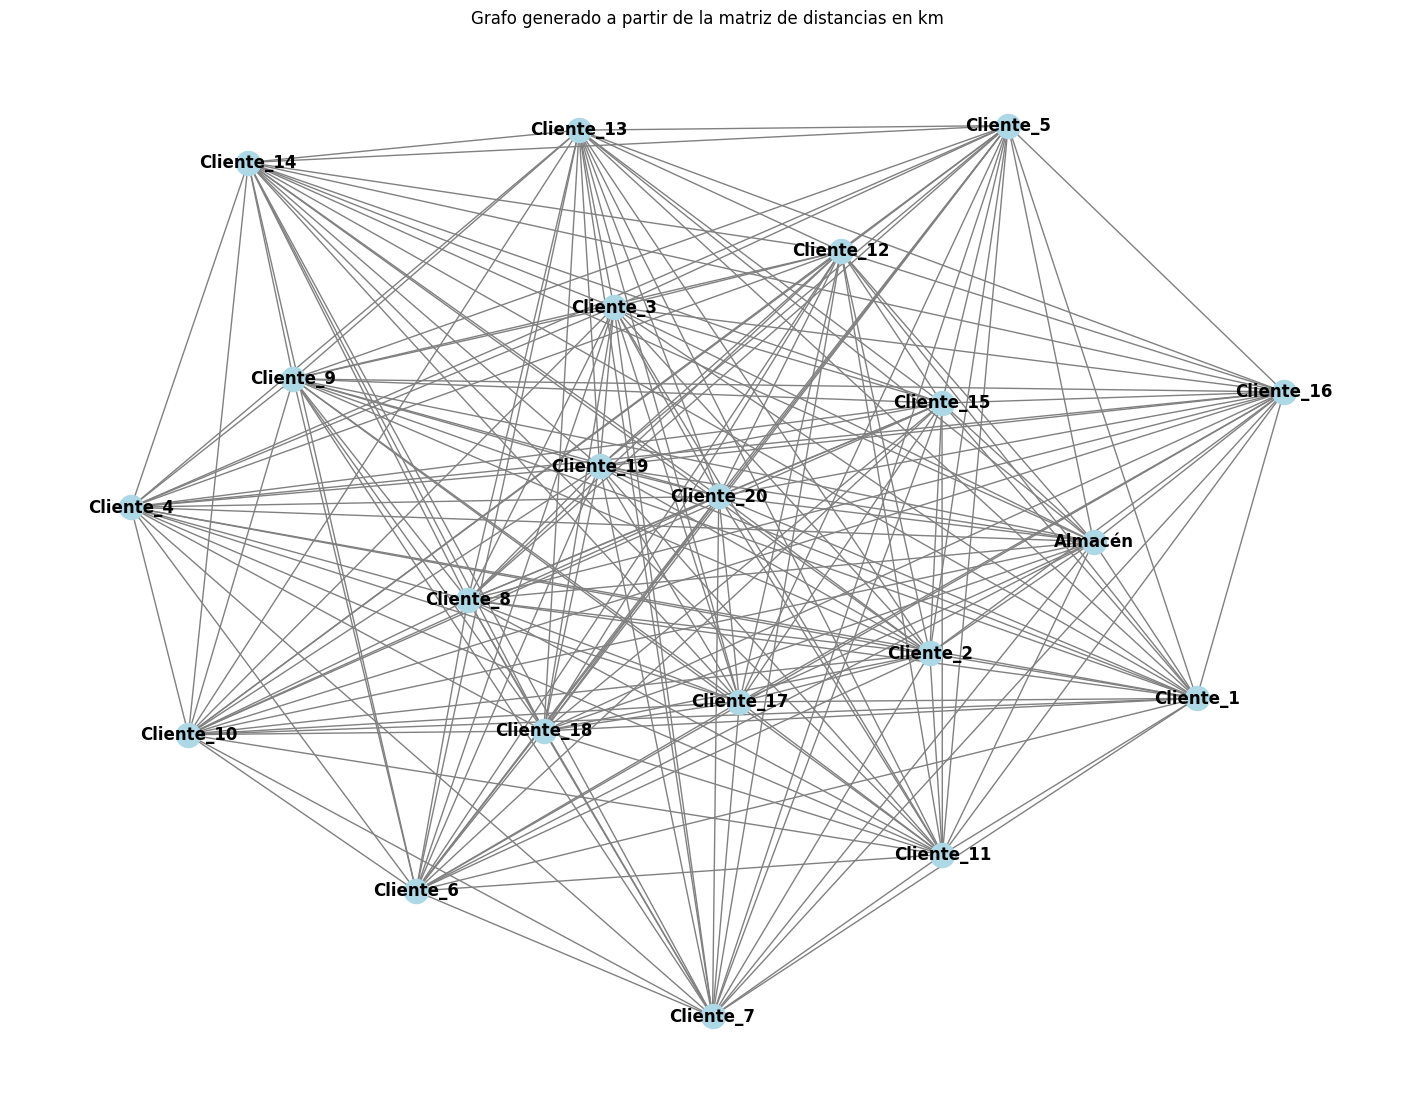

In [25]:

# Convertir la matriz de distancias a una lista de aristas
edges = []
for i, source in enumerate(df_distance_km.columns):
    for j, target in enumerate(df_distance_km.columns):
        if i != j:  # Excluir distancias de un nodo consigo mismo
            weight = round(df_distance_km.iloc[i, j], 2)
            edges.append((source, target, weight))

# Crear el grafo en NetworkX
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Representación gráfica del grafo
fig, ax = plt.subplots(figsize=(18, 14))
pos = nx.spring_layout(G, seed=42)  # Layout para mantener posiciones consistentes
nx.draw(G, pos, with_labels=True, ax=ax, node_color='lightblue', edge_color='gray', font_weight='bold')

# Mostrar pesos en las aristas
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)


plt.title("Grafo generado a partir de la matriz de distancias en km")
plt.show()

Grafo generado a partir de la matriz de distancias en min

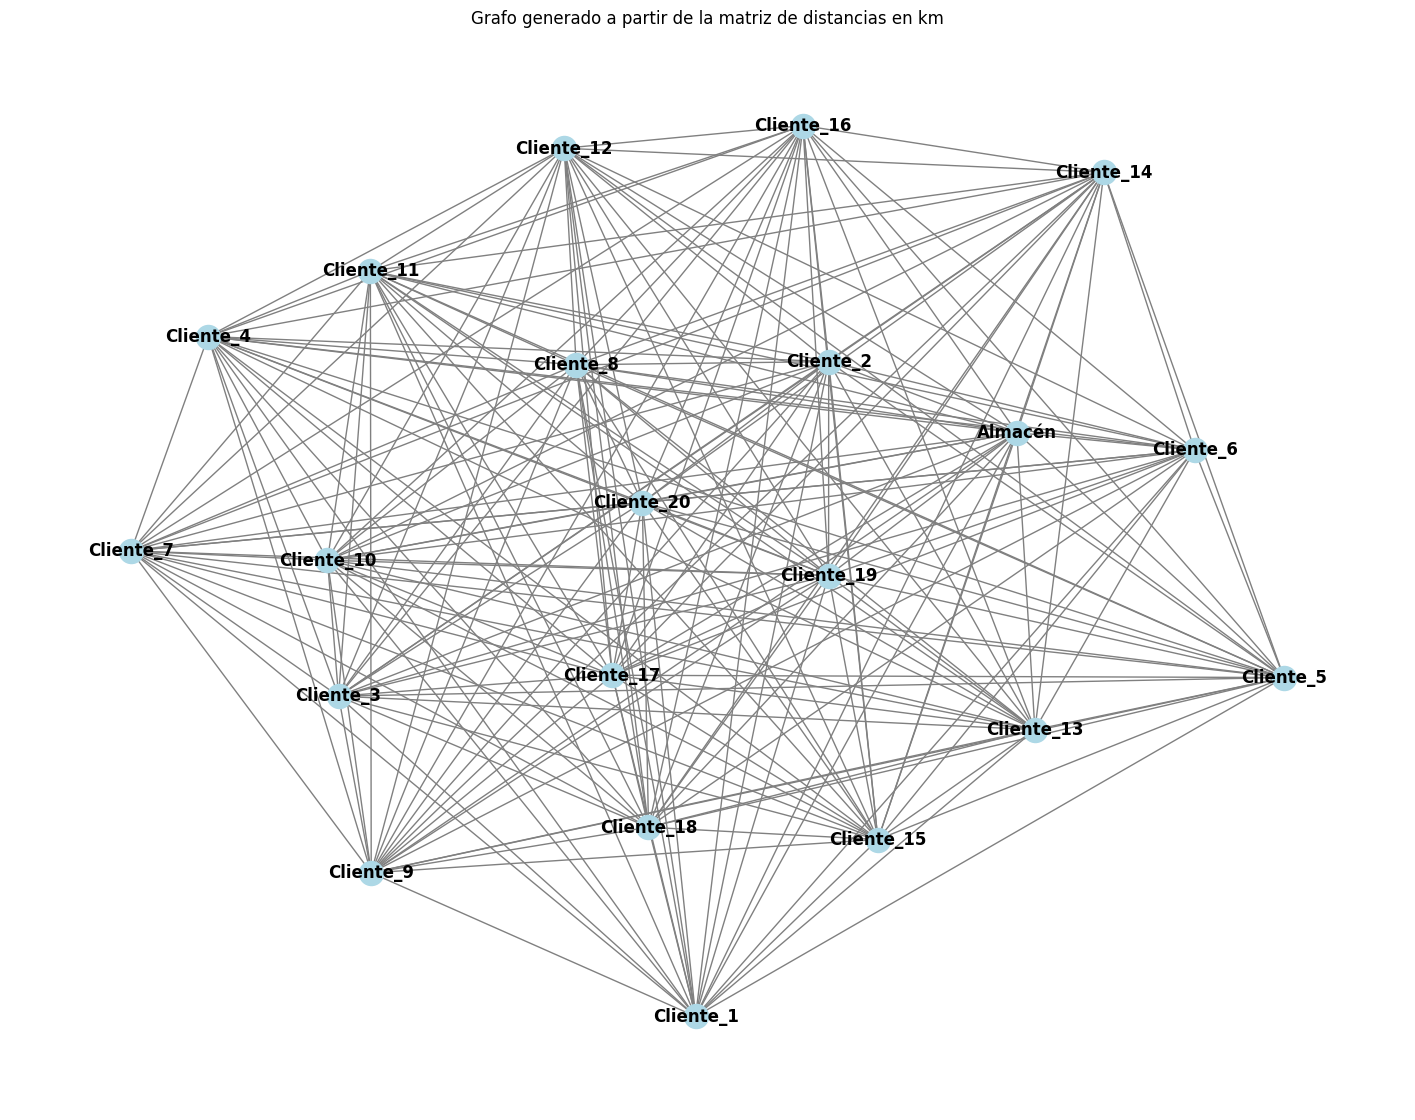

In [26]:
# Convertir la matriz de distancias a una lista de aristas
edges = []
for i, source in enumerate(df_distance_min.columns):
    for j, target in enumerate(df_distance_min.columns):
        if i != j:  # Excluir distancias de un nodo consigo mismo
            weight = round(df_distance_min.iloc[i, j], 2)
            edges.append((source, target, weight))

# Crear el grafo en NetworkX
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Representación gráfica del grafo
fig, ax = plt.subplots(figsize=(18, 14))
pos = nx.spring_layout(G, seed=42)  # Layout para mantener posiciones consistentes
nx.draw(G, pos, with_labels=True, ax=ax, node_color='lightblue', edge_color='gray', font_weight='bold')

# Mostrar pesos en las aristas
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo generado a partir de la matriz de distancias en km")
plt.show()